In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

# def LinearQuantizeIN(x, k, alpha):                # only quantize >0 values (relu must be preceded)
#     L = 2.**k - 1
#     xdiv = x.div(alpha)
#     xc = xdiv.clamp(min=0., max=1.)
#     xq = xc.mul(L).round()
#     xmul = xq.div(L).mul(alpha)
#     return xq, xmul, alpha

def LinearQuantizeOut(x, k, alpha):                # only quantize >0 values (relu must be preceded)
    L = 2.**k - 1
    xdiv = x.div(alpha)
    xc = xdiv.clamp(min=0., max=1.)
    xq = xc.mul(L).round()
    xmul = xq.div(L).mul(alpha)
    return xq, xmul, alpha / L

def LinearQuantizeW(x, k, max_val, min_val):        # asymetric quant
    delta = max_val - min_val
    L= 2 ** k - 1
    stepSize = delta
    index = torch.clamp(torch.round((x-min_val)/stepSize * L), 0, L)
    return index, index*stepSize/L + min_val, delta / L


base:  16 tensor([ 0.0000,  1.0660,  2.1320,  3.1980,  4.2640,  5.3300,  6.3960,  7.4620,
         8.5280,  9.5940, 10.6600, 11.7260, 12.7920, 13.8580, 14.9240, 15.9900])
base + max_min_norm:  16 tensor([-16.0000, -13.8673, -11.7347,  -9.6020,  -7.4693,  -5.3367,  -3.2040,
         -1.0713,   1.0613,   3.1940,   5.3267,   7.4593,   9.5920,  11.7247,
         13.8573,  15.9900])


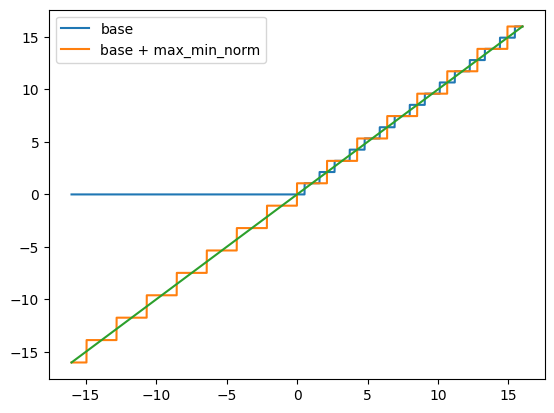

In [2]:
import matplotlib.pyplot as plt

bit=4
x = torch.arange(-16, 16, step=0.01)
a1, a2, a3 = LinearQuantizeOut(x, bit, x.max())
b1, b2, b3 = LinearQuantizeW(x, bit, x.max(), x.min())

uniqs = torch.unique(a2)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(b2)
print("base + max_min_norm: ", len(uniqs), uniqs)

plt.plot(x, a2.flatten(), label="base")
plt.plot(x, b2.flatten(), label="base + max_min_norm")
plt.plot(x, x.flatten())
plt.legend()
plt.show()

In [3]:
import torch.nn.functional as F

def linear(input, weight, bitActivation, bitWeight, subArray, ADCprecision, infer=1):
    outputOrignal = F.linear(input, weight, None)
    output = torch.zeros_like(outputOrignal)
    cellBit = 1
    cellRange = 2.**cellBit
    if infer == 0:
        inputQ, _, inputS = LinearQuantizeW(input, bitActivation, input.max(), input.min())
        outputIN = torch.zeros_like(outputOrignal)
        outputIND = torch.zeros_like(outputOrignal)
        for z in range(bitActivation):
            inputB = torch.fmod(inputQ, 2)              # 12,10,14 = [0,0,0] / [0,1,1] / [1,0,1] / [1,1,1]
            inputQ = torch.round((inputQ-inputB)/2)     # 12,10,14 = [6,5,7] / [3,2,3] / [1,1,1] / [0,0,0]
            # after get the spacial kernel, need to transfer floating weight [-1, 1] to binarized ones
            weightQ, _, weightS = LinearQuantizeW(weight, bitWeight, weight.max(), weight.min())      # [-1,1] -> [0,2] -> [0,1] by mod 2 -> (2^k-1) * weight [0,1] -> -1~1 mapped to 0~2^k-1
            outputP = torch.zeros_like(outputOrignal)
            for k in range (int(bitWeight/cellBit)):
                weightB = torch.fmod(weightQ, cellRange)
                weightQ = torch.round((weightQ-weightB)/cellRange)
                # noise variation
                # variation = np.random.normal(0, vari, list(weightQ.size())).astype(np.float32)
                # weightQ = torch.round((weightQ-remainder)/cellRange)
                outputPartial = F.linear(inputB, weightB, None)
                # Add ADC quanization effects here !!!
                _, outputADC, _ = LinearQuantizeOut(outputPartial, ADCprecision, weight.shape[1])
                # shift per weight bit sequence
                outputP = outputP + outputADC * (cellRange ** k)
            # only 1-bit (all stored 1-logic)
            outputDummy = inputB.sum() # same to F.linear(inputB, torch.ones_like(weightB), None)
            _, outputDummyADC, _ = LinearQuantizeOut(outputDummy, ADCprecision, weight.shape[1])
            # shift per input bit sequence
            outputIN = outputIN + outputP * (2 ** z)
            outputIND = outputIND + outputDummyADC * (2 ** z)                          # this is basically same to sigma(input)
        # since inputQ [0, 15] when k=4, rescale output by divide 16
        output = output + inputS * (outputIN * weightS + outputIND * weight.min())    # suppose I=[0~15], W=[-8~7] -> I*W = I[0~15]*W[0~15] + I[0~15]*W_constant[-8] (which is weight.min())
    else:
        outputF = torch.zeros_like(outputOrignal)
        numSubArray = int(weight.shape[1] / subArray)
        for s in range(numSubArray):
            # different from neurosim / just initialize input again
            inputQ, _, inputS = LinearQuantizeW(input, bitActivation, input.max(), input.min())
            mask = torch.zeros_like(weight)
            mask[:,(s*subArray):(s+1)*subArray] = 1
            outputIN = torch.zeros_like(outputOrignal)
            outputIND = torch.zeros_like(outputOrignal)
            for z in range(bitActivation):
                inputB = torch.fmod(inputQ, 2)              # 12,10,14 = [0,0,0] / [0,1,1] / [1,0,1] / [1,1,1]
                inputQ = torch.round((inputQ-inputB)/2)     # 12,10,14 = [6,5,7] / [3,2,3] / [1,1,1] / [0,0,0]
                # after get the spacial kernel, need to transfer floating weight [-1, 1] to binarized ones
                weightQ, _, weightS = LinearQuantizeW(weight*mask, bitWeight, weight.max(), weight.min())      # [-1,1] -> [0,2] -> [0,1] by mod 2 -> (2^k-1) * weight [0,1] -> -1~1 mapped to 0~2^k-1
                outputP = torch.zeros_like(outputOrignal)
                for k in range (int(bitWeight/cellBit)):
                    weightB = torch.fmod(weightQ, cellRange)*mask
                    weightQ = torch.round((weightQ-weightB)/cellRange)*mask
                    # noise variation
                    # variation = np.random.normal(0, vari, list(weightQ.size())).astype(np.float32)
                    # weightQ = torch.round((weightQ-remainder)/cellRange)
                    outputPartial = F.linear(inputB, weightB, None)
                    # Add ADC quanization effects here !!!
                    _, outputADC, _ = LinearQuantizeOut(outputPartial, ADCprecision, subArray)
                    # shift per weight bit sequence
                    outputP = outputP + outputADC * (cellRange ** k)
                # only 1-bit (all stored 1-logic)
                outputDummy = F.linear(inputB, torch.ones_like(weightB)*mask, None)
                _, outputDummyADC, _ = LinearQuantizeOut(outputDummy, ADCprecision, subArray)
                # shift per input bit sequence
                outputIN = outputIN + outputP * (2 ** z)
                outputIND = outputIND + outputDummyADC * (2 ** z)                           # this is basically same to sigma(input)
            # since inputQ [0, 15] when k=4, rescale output by divide 16
            outputF = outputF + inputS * (outputIN * weightS + outputIND * weight.min())    # suppose I=[0~15], W=[-8~7] -> I*W = I[0~15]*W[0~15] + I[0~15]*W_constant[-8] (which is weight.min())
        output = output + outputF
    print(outputIND * weight.min())
    print(F.linear(input, weight, None))
    print(output)
    return output

In [4]:
x = torch.arange(0, 16, step=1).reshape(1, 16)
w = torch.arange(0, 16, step=1).reshape(1, 16)
print(x.size(), w.size())

out = linear(x, w, 4, 4, 16, 32)

torch.Size([1, 16]) torch.Size([1, 16])
tensor([[0.]])
tensor([[1240]])
tensor([[1240.]])


In [5]:
x = torch.arange(0, 16, step=1).reshape(1, 16)
w = torch.arange(-8, 8, step=1).reshape(1, 16)
print(x.size(), w.size())

out = linear(x, w, 4, 4, 16, 32)

torch.Size([1, 16]) torch.Size([1, 16])
tensor([[-960.]])
tensor([[280]])
tensor([[280.]])


In [6]:
x = torch.arange(0, 16, step=1).reshape(1, 16) / 4.5
w = torch.arange(-8, 8, step=1).reshape(1, 16) / 6.1
print(x.size(), w.size())

out = linear(x, w, 4, 4, 16, 32)

torch.Size([1, 16]) torch.Size([1, 16])
tensor([[-157.3770]])
tensor([[10.2004]])
tensor([[10.2004]])


In [7]:
x = torch.arange(0, 16, step=1).reshape(1, 16)
w = torch.arange(0, 16, step=1).reshape(1, 16)
print(x.size(), w.size())

out = linear(x, w, 4, 4, 8, 32)

torch.Size([1, 16]) torch.Size([1, 16])
tensor([[0.]])
tensor([[1240]])
tensor([[1240.]])


In [8]:
x = torch.arange(0, 16, step=1).reshape(1, 16)
w = torch.arange(0, 16, step=1).reshape(1, 16)
print(x.size(), w.size())

out = linear(x, w, 4, 4, 64, 32)

torch.Size([1, 16]) torch.Size([1, 16])


UnboundLocalError: local variable 'outputIND' referenced before assignment

In [10]:

def LinearQuantizeOut(x, k, alpha):                # only quantize >0 values (relu must be preceded)
    L = 2.**k - 1
    xdiv = x.div(alpha)
    xc = xdiv.clamp(min=0., max=1.)
    xq = xc.mul(L).round()
    xmul = xq.div(L).mul(alpha)
    return xq, xmul, alpha / L

x = torch.arange(0, 16, step=1)
o = LinearQuantizeOut(x, k=4, alpha=512)
print(x)
print(o)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 34.13333333333333)
